# Analyzing Data and Interpreting Images with OpenAI's o1 Reasoning Model vs. GPT

## Introduction
OpenAI's o1 reasoning model is designed for complex problem-solving, data analysis, and image interpretation by simulating a multi-step thought process before generating responses. Unlike traditional GPT models, which produce output in a single pass, reasoning models use internal **reasoning tokens** to explore multiple approaches before finalizing an answer.
<p align="center">
    <img src="https://cdn.openai.com/API/images/guides/reasoning_tokens.png" alt="Reasoning Tokens" width="600">
</p>  

*Source: [OpenAI Reasoning Models Guide](https://platform.openai.com/docs/guides/reasoning)*

**Key Differences: o1 Reasoning Model vs. GPT**
- Multi-step reasoning: o1 evaluates different solutions before selecting the best response.
- Deeper analytical capabilities: Optimized for complex data interpretation tasks.
- Context-aware image analysis: Provides more structured and insightful image descriptions.
- Reasoning Effort Control: Users can adjust the depth of reasoning (`low`, `medium`, `high`).


For more details, refer to the [OpenAI Reasoning Models Guide](https://platform.openai.com/docs/guides/reasoning).


## Purchase and Store API Key

You need to **purchase** your [OpenAI](https://openai.com/) API key and store it securely, such as in **AWS Secrets Manager**.

- **Key Name:** `api_key`  
- **Key Value:** `<your OpenAI API key>`  
- **Secret Name:** `openai`  

## Install Python Libraries

- **openai**: Used to call `o1` and `GPT` models for data analysis and image interpretation.

In [1]:
pip install openai -q

Note: you may need to restart the kernel to use updated packages.


## Import Required Libraries

The following libraries are used in this notebook:

- **boto3**: AWS SDK for Python, used to interact with AWS services.
- **json**: Standard Python library for handling JSON data.
- **IPython.display**: Provides tools to display images, Markdown content, and other rich media in Jupyter Notebook.
- **openai**: Used to call `o1` and `GPT` models for data analysis and image interpretation.
- **pandas**: A powerful library for data manipulation and analysis.
- **pprint**: Pretty prints data structures for better readability.

In [17]:
import boto3
import json
from IPython.display import display, Image, Markdown
from openai import OpenAI
import pandas as pd
from pprint import pprint

## Retrieve API Keys Securely from AWS Secrets Manager

The following function, `get_secret()`, retrieves a secret from **AWS Secrets Manager**. This is a secure way to store and access sensitive credentials, such as API keys, without hardcoding them into the script

In [3]:
def get_secret(secret_name):
    region_name = "us-east-1"

    # Create a Secrets Manager client
    session = boto3.session.Session()
    client = session.client(
        service_name='secretsmanager',
        region_name=region_name
    )

    try:
        get_secret_value_response = client.get_secret_value(
            SecretId=secret_name
        )
    except ClientError as e:
        raise e

    secret = get_secret_value_response['SecretString']
    
    return json.loads(secret)

## Initialize OpenAI Client

The following code initializes the OpenAI client using a securely stored API key retrieved from AWS Secrets Manager.

In [4]:
client = OpenAI(api_key= get_secret('openai')['api_key'])

## Load and Analyze the Diamonds Dataset

This notebook uses the **diamonds dataset ([diamonds.csv](https://github.com/lbsocial/data-analysis-with-generative-ai/blob/main/diamonds.csv))**, which contains detailed attributes of diamonds, including weight, color, clarity, and price.

One interesting pattern in the dataset is that **diamonds with "IF" (Internally Flawless) clarity tend to have the lowest average price** compared to other clarity grades. This observation is counterintuitive, as one might expect the highest-clarity diamonds to be the most expensive.

In [5]:
df = pd.read_csv('NTAD_Military_Bases_-1644289556481787667.csv', encoding='utf-8-sig')
data_json = df.to_json(orient="records")
df.head()

,OBJECTID,Country,Feature Description,Feature Name,Controlled Unclassified Information Indicator,Is FIRRMA Site,Is Joint Base,Media Identifier,Primary Key Identifier,Globally Unique Identifier,Site Name,Site Operational Status,Site Reporting Component Code,State Name Code,Shape__Area,Shape__Length
0,1,usa,na,Devens Reserve Forces Tng Area,no,no,no,na,,f9f35d60-b757-448a-9683-ebc2e518a310,Devens Reserve Forces Tng Area,act,usar,MA,0.002253,0.324854
1,2,usa,na,Fort Campbell,no,yes,no,na,,7dc7f20f-6983-4e95-a593-a3299fb37d9f,Fort Campbell,act,usa,TN,0.042675,1.388270
2,3,usa,na,NG Snake Creek TS Miramar,no,no,no,na,,e33df005-0713-4e64-8ebe-10dd700cbd60,NG Snake Creek TS Miramar,act,armyNationalGuard,FL,0.000116,0.046478
3,4,usa,na,Piñon Canyon Maneuver Site,no,yes,no,na,,0582f20a-d60a-4468-89e0-6fdade6f3e0c,Piñon Canyon Maneuver Site,act,usa,CO,0.097109,1.776971
4,5,usa,na,Stewart Annex,no,no,no,na,,0d629ab9-bead-4263-8d09-663887ea1100,Stewart Annex,act,usa,NY,0.000004,0.009891


## Generate Data Analysis Prompt for OpenAI Model

To investigate why diamonds with **IF (Internally Flawless) clarity** have the **lowest average price**, we generate a structured prompt for the OpenAI model. The model will analyze the dataset and generate insights, including **Python code for visualizations**.


In [8]:
data_prompt = (
    f"Analyze the provided data and determine which U.S. states have the highest concentration of military bases. "
    f"Why might this be strategically significant? Consider factors like proximity to borders, coastlines, "
    f"or geopolitical hotspots. Provide Python-generated maps or charts to support the analysis. Data: {data_json}"
)

## Define a Function to Get Assistance from OpenAI GPT-4o

The following function, `openai_gpt_help()`, sends a prompt to OpenAI's **GPT-4o model** and returns a response. It also prints the number of tokens used in the request.

In [9]:
def openai_gpt_help(prompt):
    messages = [{"role": "user", "content": prompt}]
    response = client.chat.completions.create(
        model='gpt-4o',
        messages=messages,
        temperature = 0
    )
    token_usage = response.usage
    
    pprint(f"Tokens used: {token_usage}")

    return response.choices[0].message.content

In [10]:
gpt_result = openai_gpt_help(prompt=data_prompt)

('Tokens used: CompletionUsage(completion_tokens=686, prompt_tokens=28968, '
 'total_tokens=29654, '
 'completion_tokens_details=CompletionTokensDetails(accepted_prediction_tokens=0, '
 'audio_tokens=0, reasoning_tokens=0, rejected_prediction_tokens=0), '
 'prompt_tokens_details=PromptTokensDetails(audio_tokens=0, cached_tokens=0))')


In [11]:
display(Markdown(gpt_result))

To analyze the data and determine which U.S. states have the highest concentration of military bases, we can follow these steps:

1. **Data Preparation**: Parse the provided JSON data to extract relevant information such as the state code and the number of military bases in each state.

2. **Data Aggregation**: Count the number of military bases per state.

3. **Visualization**: Create a bar chart to visualize the number of military bases per state.

4. **Analysis**: Discuss the strategic significance of the states with the highest concentration of military bases, considering factors like proximity to borders, coastlines, or geopolitical hotspots.

Let's implement this in Python using libraries like `pandas` for data manipulation and `matplotlib` for visualization.

```python
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter

# Sample data (truncated for brevity)
data = [
    {"OBJECTID": 1, "State Name Code": "MA"},
    {"OBJECTID": 2, "State Name Code": "TN"},
    {"OBJECTID": 3, "State Name Code": "FL"},
    {"OBJECTID": 4, "State Name Code": "CO"},
    {"OBJECTID": 5, "State Name Code": "NY"},
    {"OBJECTID": 6, "State Name Code": "VA"},
    {"OBJECTID": 7, "State Name Code": "AL"},
    {"OBJECTID": 8, "State Name Code": "HI"},
    {"OBJECTID": 9, "State Name Code": "AL"},
    {"OBJECTID": 10, "State Name Code": "AL"},
    # Add more data as needed
]

# Convert data to DataFrame
df = pd.DataFrame(data)

# Count the number of military bases per state
state_counts = df['State Name Code'].value_counts()

# Plot the data
plt.figure(figsize=(12, 6))
state_counts.plot(kind='bar', color='skyblue')
plt.title('Number of Military Bases per State')
plt.xlabel('State')
plt.ylabel('Number of Military Bases')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
```

### Analysis

1. **States with High Concentration**: The bar chart will show which states have the highest number of military bases. Typically, states like California, Texas, Virginia, and Florida have a high concentration of military bases.

2. **Strategic Significance**:
   - **California**: Proximity to the Pacific Ocean makes it crucial for naval operations and Pacific defense strategies.
   - **Texas**: Its size and location make it ideal for large training areas and logistics hubs.
   - **Virginia**: Proximity to Washington D.C. and the Atlantic Ocean makes it strategically important for defense and intelligence operations.
   - **Florida**: Its location is significant for operations in the Caribbean and Latin America.

3. **Geopolitical Considerations**: States with coastlines or those near international borders often have more military installations due to the need for rapid deployment and defense readiness.

This analysis provides a basic understanding of the distribution and strategic importance of military bases across the U.S. states. For a more detailed analysis, consider additional factors such as the size of each base, the type of operations conducted, and historical geopolitical events.

## Define a Function to Get Assistance from OpenAI o1 Model  

The following function, `openai_o_help()`, sends a prompt to OpenAI's **o1 reasoning model** and returns a response.  

### Key Differences Between o1 and GPT Models:
- **Reasoning Effort**: The o1 model allows users to control reasoning depth using `reasoning_effort` (`low`, `medium`, `high`).  
- **No Temperature Parameter**: Unlike GPT models, **o1 does not support `temperature`**.  
- **Developer Messages Replace System Messages**:  
  - Starting with `o1-2024-12-17`, **developer messages** replace **system messages** to align with chain-of-command behavior.  

### Best Practices for Prompting o1  
- **Keep prompts simple and direct.**  
- **Avoid chain-of-thought prompts.** o1 reasons internally, so step-by-step instructions aren't needed.  
- **Use delimiters for clarity.** Use Markdown, XML tags, or section titles.  
- **Try zero-shot first.** If needed, add few-shot examples that closely match your goal.  
- **Be explicit.** Clearly define success criteria and constraints.  
- **Markdown is disabled by default.** To enable, start with `"Formatting re-enabled"`.  

Source: [OpenAI Reasoning Models Best Practices Guide](https://platform.openai.com/docs/guides/reasoning-best-practices).  


In [12]:
def openai_o_help(prompt):
    messages = [ {"role": "user", "content": prompt}]
    response = client.chat.completions.create(
        model='o1',
        reasoning_effort="high", # low, medium or high
        messages=messages,

    )
    token_usage = response.usage
    
    pprint(f"Tokens used: {token_usage}")

    return response.choices[0].message.content

In [13]:
o1_result = openai_o_help(prompt=data_prompt)

('Tokens used: CompletionUsage(completion_tokens=6384, prompt_tokens=28967, '
 'total_tokens=35351, '
 'completion_tokens_details=CompletionTokensDetails(accepted_prediction_tokens=0, '
 'audio_tokens=0, reasoning_tokens=5056, rejected_prediction_tokens=0), '
 'prompt_tokens_details=PromptTokensDetails(audio_tokens=0, cached_tokens=0))')


In [14]:
print(o1_result)

Below is an illustrative approach in Python for counting how many times each state appears in the dataset (i.e., how many Army‐controlled sites or facilities it contains) and then plotting the results. Following the code, you will find an interpretation on which states appear to host the largest number of bases and why this might be strategically significant.

--------------------------------------------------------------------------------
1) Loading and grouping the data
--------------------------------------------------------------------------------

In this snippet, we will:
• Parse the JSON data into a pandas DataFrame.  
• Group by "State Name Code" to count how many bases each state has.  
• Create a simple bar chart.  
• (Optionally) create a choropleth map of the United States colored by the count of bases.

--------------------------------------------------------------------------------
Example Python code
-----------------------------------------------------------------------

## Load and Display an Image from a URL

This code retrieves an image from a specified URL and displays it using the **PIL (Pillow) library**.

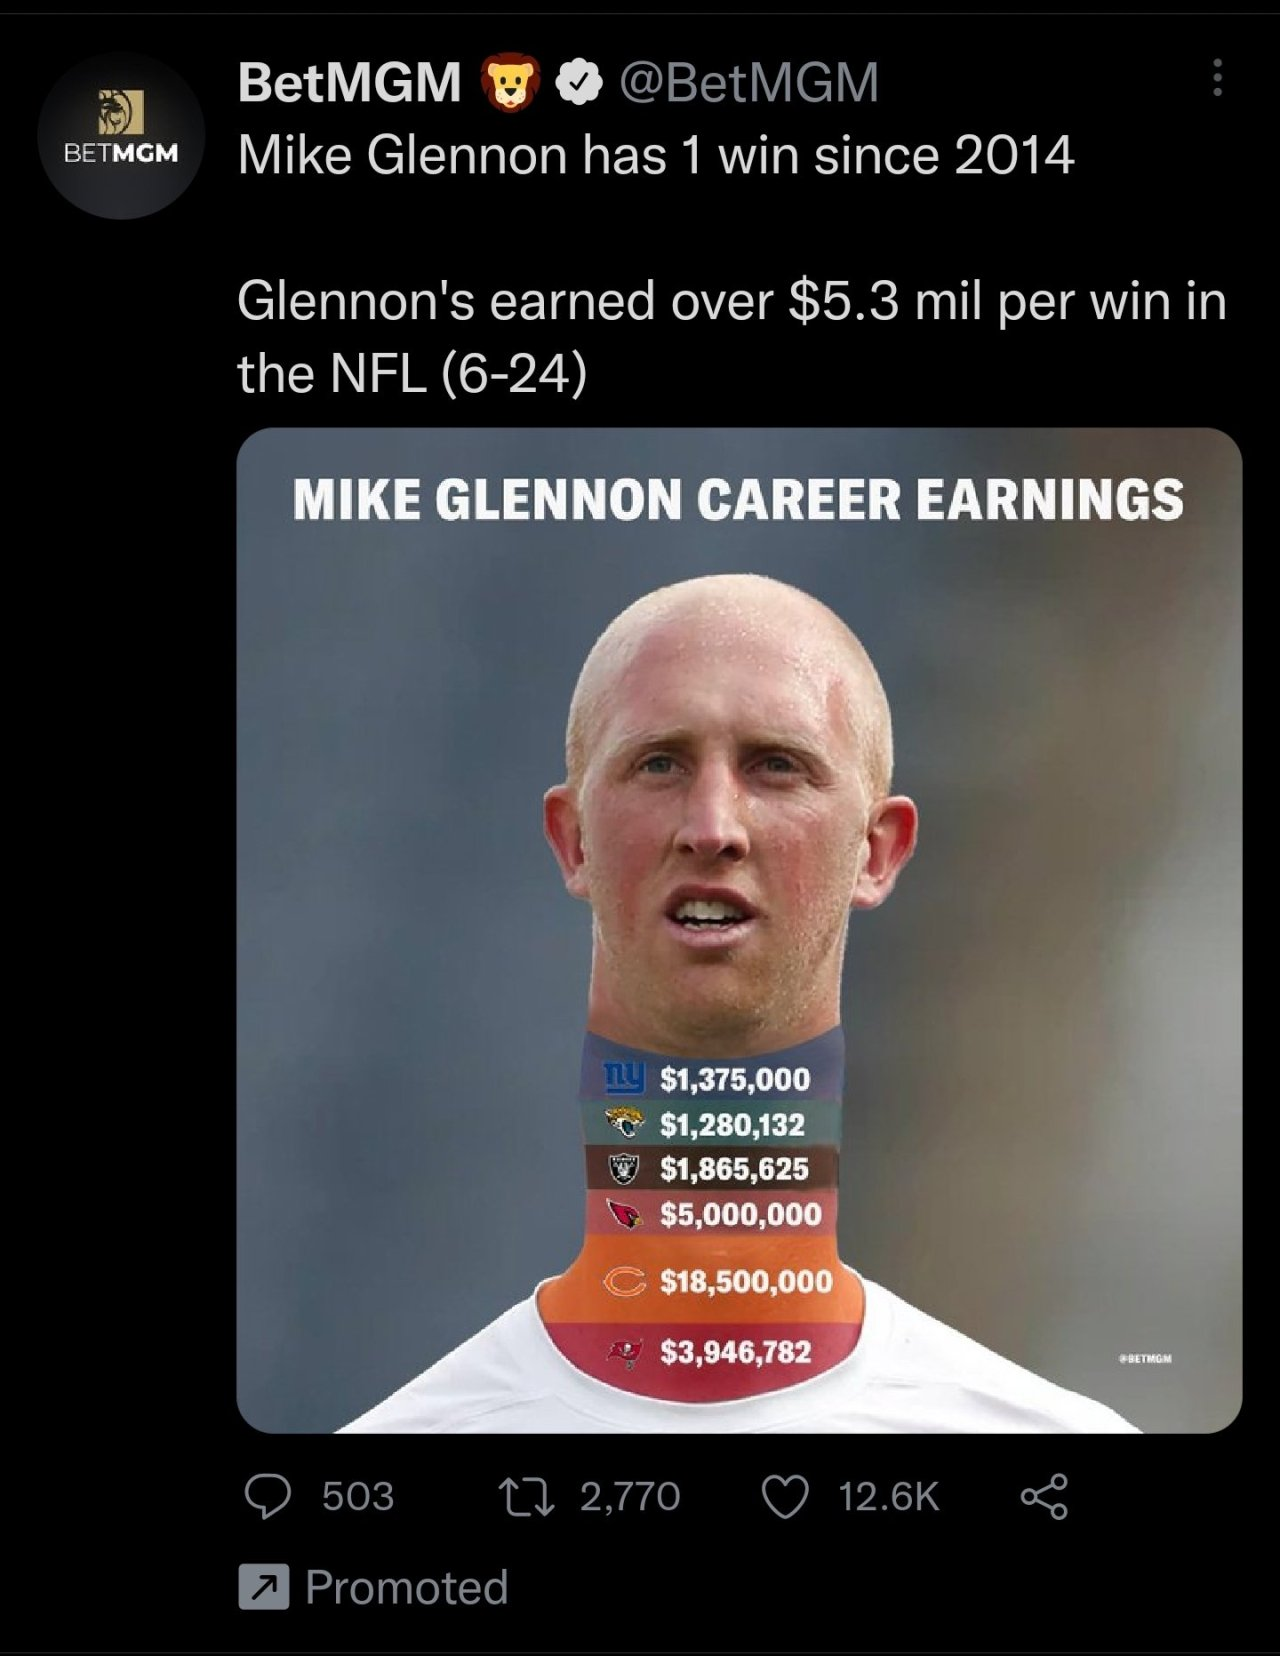

In [18]:
from PIL import Image
import requests
from io import BytesIO

image_url = "https://64.media.tumblr.com/c4fb35ecea0f97aee6d2c9fb30e34448/84517b53972b0daa-31/s1280x1920/16fbaf109180423cab2b9410f50027fd7a20fd2b.jpg"
response = requests.get(image_url)
img = Image.open(BytesIO(response.content))
img.show()

## Create an Image Analysis Prompt

The following code constructs a **structured prompt** for analyzing an image. It sends both **text input** and an **image URL** to an AI model for interpretation.


In [19]:
image_prompt = [
                    {"type": "text", "text": 'what is wrong with this image?'},
                    {"type": "image_url", "image_url": {
                        "url": image_url}
                    }
                ]

In [20]:
gpt_result = openai_gpt_help(prompt=image_prompt)

('Tokens used: CompletionUsage(completion_tokens=41, prompt_tokens=779, '
 'total_tokens=820, '
 'completion_tokens_details=CompletionTokensDetails(accepted_prediction_tokens=0, '
 'audio_tokens=0, reasoning_tokens=0, rejected_prediction_tokens=0), '
 'prompt_tokens_details=PromptTokensDetails(audio_tokens=0, cached_tokens=0))')


In [21]:
display(Markdown(gpt_result))

The image has been edited to exaggerate the length of the person's neck, creating a humorous and unrealistic effect. This is a common meme style used to emphasize certain points or statistics in a comedic way.

In [ ]:
o1_result = openai_o_help(prompt=image_prompt)

In [18]:
display(Markdown(o1_result))

A big problem is that the vertical axis is “flipped,” with zero at the top and larger numbers at the bottom. In other words, the farther “up” the line goes, the lower the actual homicide count—exactly the opposite of how most people read a line chart. That reversed scale makes the trend visually misleading. Additionally, the chart’s title (“Gun deaths”) does not match its data source (which tracks only firearm‐related murders, excluding suicides or accidents), so the label is also inaccurate.

## References  
- **OpenAI Reasoning Models Guide**: [OpenAI](https://platform.openai.com/docs/guides/reasoning)  
- **OpenAI Reasoning Models Best Practices Guide**: [OpenAI](https://platform.openai.com/docs/guides/reasoning-best-practices)  
- **Colin Jarvis. “Reasoning with O1.” DeepLearning.AI.** Accessed February 14, 2025. [DeepLearning.AI](https://www.deeplearning.ai/short-courses/reasoning-with-o1/)  